In [1]:
# Dataset (Pheme9)

In [20]:
import numpy as np
import pandas as pd

In [90]:
import os
path = r'D:\論文\PHEME9\Data\CSV'
import pathlib
data_temp = sorted(pathlib.Path(path).glob('*-2.csv'))

i = 0
all_data = pd.DataFrame()
size = 0 

while i <len(data_temp):
    rep = pd.read_csv(data_temp[i],encoding = 'utf-8', header = 0)
    src = pd.read_csv(data_temp[i+1], encoding = 'utf-8', header =0)
    df_merge = pd.merge(rep, src[['src_tweet_id','cleaned_src_tw','src_sentiment','src_emo_ro']],\
               on='src_tweet_id')
    length = rep.shape[0]
    size = size +length
    print(size)
    all_data = all_data.append(df_merge)
    i = i+2

33628
55357
58961
59125
69503
70126
70698
92055


In [92]:
all_data.reset_index(drop=True,inplace=True)
all_data.head(1)

,src_tweet_id,src_user_id,src_tweet,src_date,reply_tweet_id,reply_user_id,reply_tweet,reply_date,label,cleaned_reply_tw,reply_sentiment,reply_emo_ro,cleaned_src_tw,src_sentiment,src_emo_ro
0,552784600502915072,331658004,Charlie Hebdo became well known for publishing...,Wed Jan 07 11:11:33 +0000 2015,5.527852e+17,18370911.0,"Now 10 dead in a shooting there today RT ""@BBC...",Wed Jan 07 11:14:08 +0000 2015,0,dead shoot today,Negative,sadness,charlie hebdo become well know publish muhamme...,Positive,joy


In [12]:
all_data.shape

(92055, 15)

In [13]:
all_data.columns

Index(['src_tweet_id', 'src_user_id', 'src_tweet', 'src_date',
       'reply_tweet_id', 'reply_user_id', 'reply_tweet', 'reply_date', 'label',
       'cleaned_reply_tw', 'reply_sentiment', 'reply_emo_ro', 'cleaned_src_tw',
       'src_sentiment', 'src_emo_ro'],
      dtype='object')

# Glove embedding

In [101]:
texts = all_data.cleaned_reply_tw.fillna("").tolist()


In [17]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [103]:
# Cuts off reviews after 100 words
maxlen = 100  

#Considers only the top 10,000 words in the dataset
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 49011 unique tokens.


In [106]:
data = pad_sequences(sequences, maxlen=maxlen)

In [108]:
np.array([10, 20, 30, 40, 50]).shape

(5,)

In [109]:
all_data['word_vectors'] = pd.Series(data)

ValueError: Data must be 1-dimensional

In [80]:
all_data.loc[0,'cleaned_reply_tw']

0                                     dead shoot today
0    black teenage boys not men children stop refer...
0                                            pasajeros
0                                                  NaN
0                                        relate stjean
0       lol hopefully stock summer range pop australia
0                                                  gas
0                                               sicken
Name: cleaned_reply_tw, dtype: object

In [ ]:
'''
Splits the data into a training set and a validation set, but first shuffles the data, because you’re starting with data in which samples are ordered (all negative first, then all positive)
'''
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples] 
y_val = labels[training_samples: training_samples + validation_samples]

In [7]:
from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import common_texts,get_tmpfile, datapath

In [49]:
embeddings_index = {}
f = open(r'D:\論文\GloVe vector\glove.twitter.27B.100d.txt',encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('embeddings_index example: {}'.format(embeddings_index['school']))
print('Found %s word vectors.' % len(embeddings_index))

embeddings_index example: [ 0.11078   -0.24165    0.58407    0.33004   -0.28523    0.39694
  0.48903    1.3905    -0.75806   -0.0066963 -0.30907    0.18059
 -4.5539     0.46777   -0.35242   -0.28211   -0.81762   -0.16247
 -1.4519    -0.54034   -0.20429    0.048978  -0.67599    0.56651
  0.66277   -0.094981  -0.39577   -0.88254    0.007897  -1.0843
 -0.35871   -0.21915   -0.26527   -0.032049   0.02007    0.44382
  0.39047    1.2238     0.62872   -0.1833    -1.1305     0.29216
 -0.15579   -0.357     -0.071372   0.15666    0.11832    0.44056
 -0.9165    -0.17102    0.33795    0.14644   -0.4715     0.22617
 -0.53264   -0.43504   -0.73209   -0.23924   -0.78109    0.37778
 -0.5164     0.030757   0.49751   -0.79576   -0.63072   -0.40766
  0.032427  -0.31238    0.54056   -0.99269   -0.17894    0.096784
  0.34071    0.27062   -0.23308   -0.050616   0.59956   -0.29787
  0.4078    -0.50386    1.7127    -0.72348    0.30162   -0.38823
  0.53881   -0.20311   -0.11727   -0.34253    0.50525   -0.32589

In [53]:
num_words = min(max_words, len(word_index)+1)

In [24]:
#Considers only the top 10,000 words in the dataset
embedding_dim = 100

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i <= max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            '''
            Words not found in the embedding index will be all zeros.
            '''
            embedding_matrix[i] = embedding_vector

In [9]:
#Listing 6.12 Model definition
maxlen = 100
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen)) 
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

In [64]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
63/63 [==============================] - 3s 33ms/step - loss: 0.8158 - acc: 0.5861 - val_loss: 0.6615 - val_acc: 0.6590
Epoch 2/10
63/63 [==============================] - 2s 40ms/step - loss: 0.5714 - acc: 0.6977 - val_loss: 0.6648 - val_acc: 0.6495
Epoch 3/10
63/63 [==============================] - 5s 75ms/step - loss: 0.5363 - acc: 0.7264 - val_loss: 0.6836 - val_acc: 0.6601
Epoch 4/10
63/63 [==============================] - 2s 39ms/step - loss: 0.4579 - acc: 0.7945 - val_loss: 0.6985 - val_acc: 0.6309
Epoch 5/10
63/63 [==============================] - 4s 72ms/step - loss: 0.4045 - acc: 0.8326 - val_loss: 0.7175 - val_acc: 0.6370
Epoch 6/10
63/63 [==============================] - 4s 71ms/step - loss: 0.3713 - acc: 0.8654 - val_loss: 0.7455 - val_acc: 0.6238
Epoch 7/10
63/63 [==============================] - 2s 31ms/step - loss: 0.3346 - acc: 0.8765 - val_loss: 0.7727 - val_acc: 0.6279
Epoch 8/10
63/63 [==============================] - 3s 55ms/step - loss: 0.3224 - a

In [65]:
history.history

{'loss': [0.7496050596237183,
  0.583576500415802,
  0.5221142768859863,
  0.471637487411499,
  0.4265790283679962,
  0.3854178786277771,
  0.34866148233413696,
  0.3166767358779907,
  0.28705424070358276,
  0.25918176770210266],
 'acc': [0.6065000295639038,
  0.6955000162124634,
  0.7335000038146973,
  0.7804999947547913,
  0.8090000152587891,
  0.8429999947547913,
  0.8629999756813049,
  0.8799999952316284,
  0.8949999809265137,
  0.9104999899864197],
 'val_loss': [0.661516547203064,
  0.6647955775260925,
  0.6835546493530273,
  0.6985095739364624,
  0.7175431251525879,
  0.7455412149429321,
  0.7727019786834717,
  0.8227448463439941,
  0.8520717620849609,
  0.90094393491745],
 'val_acc': [0.6590499877929688,
  0.649524986743927,
  0.660099983215332,
  0.6308500170707703,
  0.6369500160217285,
  0.6237999796867371,
  0.6279249787330627,
  0.6391000151634216,
  0.6215000152587891,
  0.6224750280380249]}

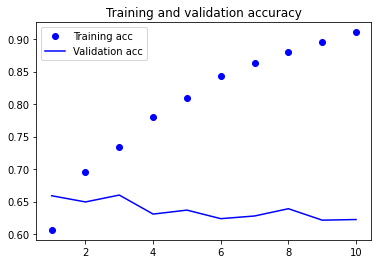

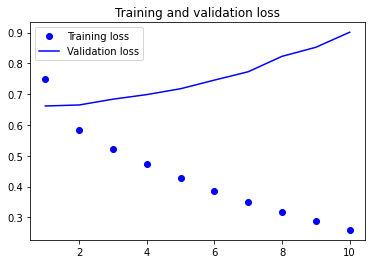

In [66]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier  # classifier from keras

In [116]:
# all_data['src_date'] = pd.to_datetime(all_data.src_date)
# all_data['reply_date'] = pd.to_datetime(all_data.reply_date)

In [123]:
all_data['src_sentiment'] = all_data['src_sentiment'].astype('category')
all_data['reply_sentiment'] = all_data['reply_sentiment'].astype('category')

In [125]:
all_data['src_emo_ro'] = all_data['src_emo_ro'].astype('category')
all_data['reply_emo_ro'] = all_data['reply_emo_ro'].astype('category')

In [117]:
all_data.columns

Index(['src_tweet_id', 'src_user_id', 'src_tweet', 'src_date',
       'reply_tweet_id', 'reply_user_id', 'reply_tweet', 'reply_date', 'label',
       'cleaned_reply_tw', 'reply_sentiment', 'reply_emo_ro', 'cleaned_src_tw',
       'src_sentiment', 'src_emo_ro'],
      dtype='object')

In [126]:
all_data.dtypes

src_tweet_id                      int64
src_user_id                       int64
src_tweet                        object
src_date            datetime64[ns, UTC]
reply_tweet_id                  float64
reply_user_id                   float64
reply_tweet                      object
reply_date          datetime64[ns, UTC]
label                             int64
cleaned_reply_tw                 object
reply_sentiment                category
reply_emo_ro                   category
cleaned_src_tw                   object
src_sentiment                  category
src_emo_ro                     category
dtype: object

In [120]:
X = all_data.loc[:,['src_date','reply_date','cleaned_reply_tw', 'reply_sentiment', 'reply_emo_ro', 'cleaned_src_tw',
       'src_sentiment', 'src_emo_ro']]
y = all_data.loc[:,'label']

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

labelencoder_X_1 = LabelEncoder() # Geography
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])

labelencoder_X_2 = LabelEncoder() #gender
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [2]:
classifier = Sequential()
classifier.add(Dense(7, input_dim=13, activation='relu'))
classifier.add(Dense(7,  activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))
classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])